In [2]:
# Imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data Preparation

In [3]:
train = pd.read_csv('titanic.csv')

# Converting Passenger Class and Embarked Location to binary variables
dummy_fields = ['Sex', 'Pclass', 'Embarked']
for i in dummy_fields:
    dummies = pd.get_dummies(train[i], prefix=i, drop_first=False)
    train = pd.concat([train, dummies], axis=1)

# Dropping unneeded columns 
fields_to_drop = ['PassengerId', 'Ticket', 'Name', 'Cabin', 'Fare', 'Pclass', 'Embarked', 'Sex']
data = train.drop(fields_to_drop, axis=1)

In [4]:
# Normalising Age
mean, std = data['Age'].mean(), data['Age'].std()
data.loc[:, 'Age'] = (data['Age'] - mean)/std

data = data.fillna(0) # Replace NaN age with mean (0)

In [5]:
# Shuffle Data 
data = data.sample(frac=1).reset_index(drop=True)

# Splitting Data into Train Val and Test Set
features, targets = data.drop('Survived', axis=1), data['Survived'] 
targets = targets.values.reshape(-1, 1) # reshaping to numpy n x 1 matrix

test_X, test_y = features[-120:], targets[-120:]
val_X, val_y = features[-200:-120], targets[-200:-120]
train_X, train_y = features[:-200], targets[:-200]

## Neural Network

In [10]:
class NeuralNetwork(object):
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        self.lr = learning_rate
        self.l2_m = 0
        self.l1_m = 0
        self.l2_v = 0
        self.l1_v = 0
        self.t = 0
        
        # Weights Initilization
        self.w0 = np.random.normal(0.0, 0.1, (self.input_nodes, self.hidden_nodes))
        self.w1 = np.random.normal(0.0, 0.1, (self.hidden_nodes, self.output_nodes))
        
        def sigmoid(x, deriv=False):
            
            if deriv:
                return x*(1-x)
            return 1/(1+np.exp(-x))
        
        self.activation_function = sigmoid
        
    def train(self, features, targets, optimizer, decay_rate_1 = None, 
              decay_rate_2 = None, epsilon = None):
        # Feed Forward
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        
        # Backpropagation
        l2_error = l2 - targets
        l2_delta = l2_error * self.activation_function(l2, deriv=True)
        l1_error = l2_delta.dot(self.w1.T)
        l1_delta = l1_error * self.activation_function(l1, deriv=True)
        
        if optimizer == 'sgd':
            # Update Weights
            self.w1 -= self.lr * l1.T.dot(l2_delta)
            self.w0 -= self.lr * l0.T.dot(l1_delta)
            
        if optimizer == 'adam':
            # Gradients for each layer
            g1 = l1.T.dot(l2_delta)
            g0 = l0.T.dot(l1_delta)
            
            self.t += 1 # Increment Time Step
            
            # Computing 1st and 2nd moment for each layer
            self.l2_m = self.l2_m * decay_rate_1 + (1- decay_rate_1) * g1
            self.l1_m = self.l1_m * decay_rate_1 + (1- decay_rate_1) * g0
            
            self.l2_v = self.l2_v * decay_rate_2 + (1- decay_rate_2) * (g1 ** 2)
            self.l1_v = self.l1_v * decay_rate_2 + (1- decay_rate_2) * (g0 ** 2)
            
            l2_m_corrected = self.l2_m / (1-(decay_rate_1 ** self.t))
            l2_v_corrected = self.l2_v / (1-(decay_rate_2 ** self.t))
            
            # Computing bias-corrected moment
            l1_m_corrected = self.l1_m / (1-(decay_rate_1 ** self.t))
            l1_v_corrected = self.l1_v / (1-(decay_rate_2 ** self.t))
            
            # Update Weights
            w1_update = l2_m_corrected / (np.sqrt(l2_v_corrected) + epsilon)
            w0_update = l1_m_corrected / (np.sqrt(l1_v_corrected) + epsilon)
            
            self.w1 -= (self.lr * w1_update)
            self.w0 -= (self.lr * w0_update)
            
    def run(self, features):
        l0 = features
        l1 = self.activation_function(np.dot(l0, self.w0))
        l2 = self.activation_function(np.dot(l1, self.w1))
        
        return l2


In [7]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Training

In [39]:
import time

def build_network(network, epochs, optimizer, batch_size = None):
    losses = {'train':[], 'validation':[]} # For Plotting of MSE

    start = time.time()
        
    # Iterating Over Epochs
    for i in range(epochs):
        
        if optimizer == 'sgd':
            # Iterating over mini batches
            for k in range(train_X.shape[0]// batch_size):
                batch = np.random.choice(train_X.index, size=batch_size)
                X, y = train_X.loc[batch].values, train_y[batch]

                network.train(X, y, optimizer)

                train_loss = MSE(network.run(train_X), train_y)
                val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))
                
        if optimizer == 'adam':
            network.train(train_X, 
                          train_y, 
                          optimizer,
                          decay_rate_1 = 0.9,
                          decay_rate_2 = 0.99,
                          epsilon = 10e-8)

            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))

   
   
 
        if optimizer == 'Adadelta':
            network.train(train_X, 
                          train_y, 
                          optimizer,
                          decay_rate_1 = 0.9,
                          decay_rate_2 = 0.99,
                          epsilon = 10e-8)

            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))
 
        if optimizer == 'Adagrad':
            network.train(train_X, 
                          train_y, 
                          optimizer,
                          decay_rate_1 = 0.9,
                          decay_rate_2 = 0.99,
                          epsilon = 10e-8)

            train_loss = MSE(network.run(train_X), train_y)
            val_loss = MSE(network.run(val_X), val_y)

            if i % 100 == 0:
                print('Epoch {}, Train Loss: {}, Val Loss: {}'.format(i, train_loss, val_loss))

        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
    print('Time Taken:{0:.4f}s'.format(time.time()-start))
    return losses

In [40]:
epochs = 601
learning_rate = 0.01
hidden_nodes = 6
output_nodes = 1
batch_size = 64

network_adam = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate)
network_sgd = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate)
network_ada = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate)
network_delta = NeuralNetwork(train_X.shape[1], hidden_nodes, output_nodes, learning_rate)

print('Training Model with Adam')
losses_adam = build_network(network_adam, epochs, 'adam')

print('Training Model with Adagrad')
losses_ada = build_network(network_ada, epochs, 'Adagrad')

print('Training Model with Adadelta')
losses_delta = build_network(network_delta, epochs, 'Adadelta')

print('\nTraining Model with SGD')
losses_sgd = build_network(network_sgd, epochs, 'sgd', batch_size)

Training Model with Adam
Epoch 0, Train Loss: 0.24127112270507564, Val Loss: 0.24512199545605623
Epoch 100, Train Loss: 0.1866985998271147, Val Loss: 0.21286166929359354
Epoch 200, Train Loss: 0.17486233958289243, Val Loss: 0.1961678855445399
Epoch 300, Train Loss: 0.13832594081008032, Val Loss: 0.15578617939577272
Epoch 400, Train Loss: 0.12452259788161245, Val Loss: 0.1397560070968748
Epoch 500, Train Loss: 0.11820803100600587, Val Loss: 0.13528423921129748
Epoch 600, Train Loss: 0.11444953456871687, Val Loss: 0.13650528448309113
Time Taken:2.6877s
Training Model with Adagrad
Epoch 0, Train Loss: 0.255904543319202, Val Loss: 0.2534571995560773
Epoch 100, Train Loss: 0.255904543319202, Val Loss: 0.2534571995560773
Epoch 200, Train Loss: 0.255904543319202, Val Loss: 0.2534571995560773
Epoch 300, Train Loss: 0.255904543319202, Val Loss: 0.2534571995560773
Epoch 400, Train Loss: 0.255904543319202, Val Loss: 0.2534571995560773
Epoch 500, Train Loss: 0.255904543319202, Val Loss: 0.25345719

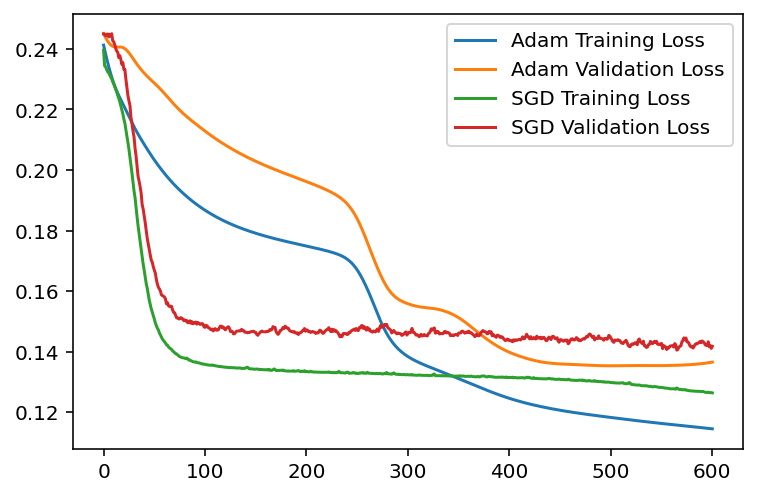

In [48]:
plt.plot(losses_adam['train'], label='Adam Training Loss')
plt.plot(losses_adam['validation'], label='Adam Validation Loss')
plt.plot(losses_sgd['train'], label='SGD Training Loss')
plt.plot(losses_sgd['validation'], label='SGD Validation Loss')
plt.legend()

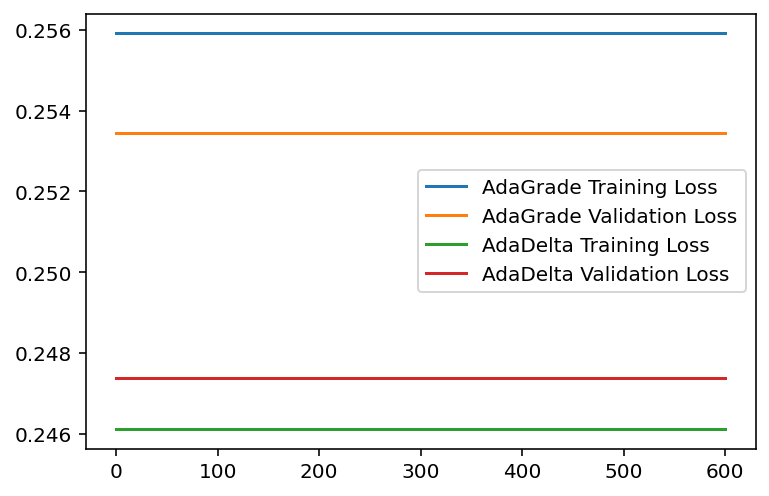

In [46]:
plt.plot(losses_ada['train'], label='AdaGrade Training Loss')
plt.plot(losses_ada['validation'], label='AdaGrade Validation Loss')
plt.plot(losses_delta['train'], label='AdaDelta Training Loss')
plt.plot(losses_delta['validation'], label='AdaDelta Validation Loss')
plt.legend()

From the plots, we can observed that using Adam, weights of the neural network are more smoothly adjusted to reduce the training loss. Try increasing the learning rate, and you can see that Adam converges much faster compared to SGD, using an adaptive learning rate.

The benefits of using Adam are not so obvious as the size of the data is very small and increasing training epochs tend to lead to overfitting and early-stopping is required. It is recommended to set the epochs for Adam to around 200 for the above hyperparameters configuration, as the training and validation loss starts diverging. However, we kept the epochs for both networks the same for plotting.

Lastly, in this implementation, Adam is much faster to compute compared to SGD as it is processed as an entire training batch.  

## Test Model

.

In [42]:
def test_model(network):
    test_predictions = network.run(test_X)
    correct = 0
    total = 0
    for i in range(len(test_predictions)):
        total += 1
        if test_predictions[i] < 0.5 and test_y[i] == 0:
            correct += 1
        elif test_predictions[i] >= 0.5 and test_y[i] == 1:
            correct += 1
    return correct/total
    

In [43]:
print('Adam Test Accuracy: {}'.format(test_model(network_adam)))
print('SGD Test Accuracy: {}'.format(test_model(network_sgd)))
print('AdaGrad Test Accuracy: {}'.format(test_model(network_ada)))
print('AdaDelta Test Accuracy: {}'.format(test_model(network_delta)))

Adam Test Accuracy: 0.8
SGD Test Accuracy: 0.8166666666666667
AdaGrad Test Accuracy: 0.4
AdaDelta Test Accuracy: 0.6
